In [1]:
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import h5py
import pickle
import seaborn as sns
import tqdm

from scipy import stats

from statsmodels.stats.multitest import multipletests

import sys
import itertools
import time
import datetime

sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import * 
import snmcseq_utils

from enhancer_gene_hic_validation_utils import *

In [2]:
default_colorbar_kws = DEFAULT_COLORBAR_KWS
today = datetime.date.today()
print(today)

2020-11-28


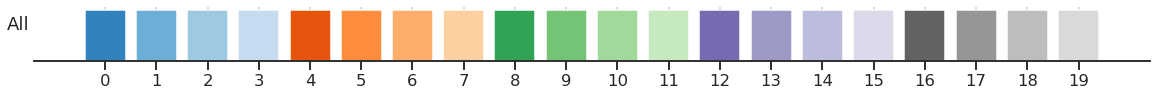

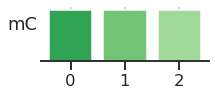

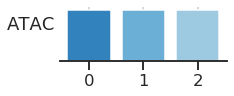

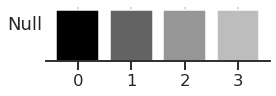

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [4]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000

# def p25(x):
#     return np.percentile(x, 25)
# def p75(x):
#     return np.percentile(x, 75)

In [5]:
def plot_contact_stats(
    chromosome, celltype, resolution,
    distances, contacts_mean, contacts_std, 
    contacts_sig_pairs_mean, contacts_sig_pairs_std, 
    track_names, colors,
    output_fig,
    ):
    """
    """
    
    fig, axs = plt.subplots(2, 4, figsize=(5*4,5*2), sharey=True, sharex=True)

    # all together
    ax = axs[0,0]
    _x, _y, _yerr = distances, contacts_mean, contacts_std
    color='gray'
    ax.plot(_x, _y, '-', color=color, linewidth=3, label='all_bins')
    for i, (_name, _color) in enumerate(zip(track_names, colors)):
        _x, _y, _yerr = distances, contacts_sig_pairs_mean[_name], contacts_sig_pairs_std[_name]
        ax.plot(_x, _y, '-', color=_color, linewidth=3, label=_name)
        
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_yscale('log')
    ax.set_xlabel('Genomic distance')
    ax.set_xlim([0, 1e5])
    ax.set_ylim([1e-3, 1e-1])
    ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')
    ax.set_title("{} {}, {} HiC resolution".format(chromosome, celltype, resolution))

    for ax in axs[0,1:]:
        ax.axis('off')

    # specific plots
    for i, (ax, _name, _color) in enumerate(zip(axs[1], track_names, colors)):
        _x, _y, _yerr = distances, contacts_mean, contacts_std
        color='gray'
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.2)
        ax.plot(_x, _y, '-', color=color, linewidth=5, label='all_bins', alpha=1)

        _x, _y, _yerr = distances, contacts_sig_pairs_mean[_name], contacts_sig_pairs_std[_name]
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=_color, alpha=0.2)
        ax.plot(_x, _y, '-', color=_color, linewidth=5, label=_name, alpha=1)

        ax.xaxis.set_major_formatter(mtick.EngFormatter())
        ax.set_yscale('log')
        ax.set_xlabel('Genomic distance')
        ax.set_xlim([0, 1e5])
        ax.set_ylim([1e-3, 1e-1])

        if i == 0:
            ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')

    # legends
    handles, labels = snmcseq_utils.combine_legends(axs.flat)
    handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    axs[0,1].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
    
    snmcseq_utils.savefig(fig, output_fig)
#     plt.show()
    
    plt.close()
    return 

In [6]:
chromosomes = ['chr'+str(i+1) for i in range(22)] + ['chrX']
celltypes = ['L2_3', 'L4', 'L5', 'L6', 
             'Pvalb', 'Sst', 'Vip', 'Ndnf']
resolution = 10000


celltype = 'L2_3'
chromosome = 'chr1'

# HiC-analysis - use only cell type-specific pairs

Todo: 
- make sure the enhancer indices are correct 
- make sure the HiC map indices are correct


- record the results for every pair
- do a t-test against the random shuffled distribution for each cell type 

In [7]:
# enhancers lifted
f = './hic_from_ethan/enhancers_lifted.bed'
enh_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'enh_id'])
enh_list['center'] = (enh_list['start'] + enh_list['end'])/2
print(enh_list.shape)
enh_list.head()

# tss lifted
f = './hic_from_ethan/tss_lifted.bed'
tss_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'gid'])
print(tss_list.shape)
tss_list.head()

# enh - tss linked list
# orig significant pairs (enh_index and gid)
f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_mc.tsv'
linked_pairs_mc = pd.read_csv(f, sep="\t")
print(linked_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_atac.tsv'
linked_pairs_atac = pd.read_csv(f, sep="\t")
print(linked_pairs_atac.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_mc.tsv'
correlated_pairs_mc = pd.read_csv(f, sep="\t")
print(correlated_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_atac.tsv'
correlated_pairs_atac = pd.read_csv(f, sep="\t")
print(correlated_pairs_atac.shape)

linked_pairs_mc.head()

(126134, 5)
(33814, 4)
(7455, 3)
(3879, 3)
(85596, 3)
(50012, 3)


,gene,enh,dist
0,ENSMUSG00000000058,181997,14555
1,ENSMUSG00000000088,221978,48225
2,ENSMUSG00000000126,35942,90017
3,ENSMUSG00000000126,35953,4552
4,ENSMUSG00000000126,35954,5567


In [8]:
linked_pairs_both = pd.merge(linked_pairs_mc, linked_pairs_atac, on=['gene', 'enh', 'dist'])
correlated_pairs_both = pd.merge(correlated_pairs_mc, correlated_pairs_atac, on=['gene', 'enh', 'dist'])
print(linked_pairs_both.shape, 
      correlated_pairs_both.shape, 
     )

(1268, 3) (35309, 3)


In [9]:
# gene expression profiles
f = '/sphere/fangming/enhancers/scripts/data_organized/gene_rna_clsts.tsv'
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0) #header=True, index=True)
print(gene_rna_clsts.shape)
gene_rna_clsts.head()

# cluster annotation
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/annotations_order.tsv'
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(12095, 38)
(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

In [10]:
# merge cluster name
annot_rename_lookup = {
    'L2/3': "L2_3",
    'L4/5': "L4",
    'L6b': "L6",
    'Sncg': "Ndnf",
    'Lamp5': "Ndnf",
}

def rename_annot(x, annot_rename_lookup):
    """
    """
    if x in annot_rename_lookup.keys():
        return annot_rename_lookup[x]
    else:
        return x
    
clst_annot_broad = pd.Series([annot.split(' ')[0] for annot in clst_annot.values], 
                             index=clst_annot.index)
clst_annot_broad = clst_annot_broad.apply(lambda x: rename_annot(x, annot_rename_lookup))

print(clst_annot_broad.shape, 
      len(np.unique(clst_annot_broad.values)),
      np.unique(clst_annot_broad.values),
     )

(38,) 8 ['L2_3' 'L4' 'L5' 'L6' 'Ndnf' 'Pvalb' 'Sst' 'Vip']


In [11]:
# merge RNA profiles
_tmp = gene_rna_clsts.T
_tmp['annot'] = clst_annot_broad.loc[_tmp.index]
gene_rna_clsts_broad = _tmp.groupby('annot').median().T
gene_rna_clsts_broad_rank = gene_rna_clsts_broad.rank(pct=True, axis=1)
print(gene_rna_clsts_broad_rank.shape)
gene_rna_clsts_broad_rank.head()

(12095, 8)


annot,L2_3,L4,L5,L6,Ndnf,Pvalb,Sst,Vip
ENSMUSG00000000001,0.500,0.750,0.250,0.625,0.875,0.125,0.375,1.000
ENSMUSG00000000056,0.125,0.750,0.875,0.500,0.625,1.000,0.250,0.375
ENSMUSG00000000058,0.625,1.000,0.250,0.375,0.750,0.125,0.500,0.875
ENSMUSG00000000078,0.250,1.000,0.625,0.750,0.125,0.500,0.875,0.375
ENSMUSG00000000085,0.250,0.125,0.625,0.375,0.875,0.500,0.750,1.000


In [12]:
# print(len(_contacts), #.shape, 
#       len(_contacts_sig_pairs), #.shape,
#       list(_contacts_sig_pairs.keys()),
#       len(_contacts_sig_pairs['linked_mc']),
#      )

In [13]:
active_th = 0.5
# distances
distance_cutoff = 1e5
distance_idx = np.arange(1, int(distance_cutoff/resolution)+1)
distances = distance_idx * resolution

for celltype in celltypes:
    print(celltype)
    
    contacts = [[] for i in np.arange(len(distances))]
    contacts_sig_pairs = collections.OrderedDict({
            'linked_mc': [[] for i in np.arange(len(distances))],
            'linked_atac': [[] for i in np.arange(len(distances))],
            'linked_both': [[] for i in np.arange(len(distances))],
            'correlated_mc': [[] for i in np.arange(len(distances))],
            'correlated_atac': [[] for i in np.arange(len(distances))],
            'correlated_both': [[] for i in np.arange(len(distances))],
        })

    for chromosome in chromosomes:
        print(celltype, resolution, chromosome)

        # read in the matrix 
        resource_string = (
             '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
             '::/resolutions/{}'.format(celltype, resolution)
             )
        c = cooler.Cooler(resource_string)
        mat_all = c.matrix(balance=True).fetch(chromosome)

        # all enhancers and tss on that chromosomes
        enhs = enh_list[enh_list['chr']==chromosome]
        tsss = tss_list[tss_list['chr']==chromosome]
        
        # only include the gene if it is actively expressed (>50% across cell types)
        active_genes = gene_rna_clsts_broad_rank[gene_rna_clsts_broad_rank[celltype]>active_th].index.values
        tsss = tsss[tsss['gid'].isin(active_genes)]
        
        # get paired bins
        paired_bin_tables = collections.OrderedDict({
            'linked_mc': enh_gene_id_to_binidx(linked_pairs_mc, tsss, enhs, resolution),
            'linked_atac': enh_gene_id_to_binidx(linked_pairs_atac, tsss, enhs, resolution),
            'linked_both': enh_gene_id_to_binidx(linked_pairs_both, tsss, enhs, resolution),
            'correlated_mc': enh_gene_id_to_binidx(correlated_pairs_mc, tsss, enhs, resolution),
            'correlated_atac': enh_gene_id_to_binidx(correlated_pairs_atac, tsss, enhs, resolution),
            'correlated_both': enh_gene_id_to_binidx(correlated_pairs_both, tsss, enhs, resolution),
        })
        track_names = list(paired_bin_tables.keys())
#         colors = [
#             mod_palette_comp['mc'][0],
#             mod_palette_comp['atac'][0],
#             mod_palette_comp['mc'][2],
#             mod_palette_comp['atac'][2],
#         ]

        # contact stats: distance bin by corr values in that bin
        (_contacts, _contacts_sig_pairs
        ) = get_contacts(mat_all, paired_bin_tables, resolution, distance_idx)

        # combine all chromosomes 
        for idx, dist in enumerate(distances):
            contacts[idx] += list(_contacts[idx])
            for key in _contacts_sig_pairs.keys():
                contacts_sig_pairs[key][idx] += list(_contacts_sig_pairs[key][idx])

    # stats
    contacts_mean = np.array([np.nanmean(val) for val in contacts])
    contacts_std = np.array([np.nanstd(val) for val in contacts])
    contacts_n = np.array([len(val) for val in contacts])

    contacts_sig_pairs_mean = collections.OrderedDict({
        key: np.zeros(len(distances)) 
        for key in contacts_sig_pairs.keys()
    })
    contacts_sig_pairs_std = contacts_sig_pairs_mean.copy()
    contacts_sig_pairs_n = contacts_sig_pairs_mean.copy()

    for key in contacts_sig_pairs.keys():
        contacts_sig_pairs_mean[key] = np.array([np.nanmean(val) 
                                                 for val in contacts_sig_pairs[key]])

        contacts_sig_pairs_std[key] = np.array([np.nanstd(val) 
                                                for val in contacts_sig_pairs[key]])
        
        contacts_sig_pairs_n[key] = np.array([len(val) 
                                              for val in contacts_sig_pairs[key]])

    
    # run and save results
    output_res = ('/sphere/fangming/enhancers/scripts/results_new/'
                  'hic_contact_enrichment_celltypespec{}_{}_{}_{}.pkl'.format(int(100*active_th), celltype, resolution, today)
                 )
    print(output_res)

#     output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
#                   'hic_contact_enrichment_celltypespec{}_{}_{}_{}.pdf'.format(int(100*active_th), celltype, resolution, today)
#                  )
    # save results
    # distances, contacts_mean, contacts_std ## these are numpy arrays 
    # contacts_sig_pairs_mean, contacts_sig_pairs_std ## these
    with open(output_res, 'wb') as fwh:
        pickle.dump((distances, 
                     contacts_mean, contacts_std, contacts_n,
                     contacts_sig_pairs_mean, 
                     contacts_sig_pairs_std,
                     contacts_sig_pairs_n,
                    ), fwh)

#     # plot
#     plot_contact_stats(
#         'all_chroms', celltype, resolution,
#         distances, contacts_mean, contacts_std, 
#         contacts_sig_pairs_mean, contacts_sig_pairs_std, 
#         track_names, colors,
#         output_fig,
#         )

L2_3
L2_3 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 202.77it/s]


L2_3 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 256.94it/s]


L2_3 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 341.43it/s]


L2_3 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 317.10it/s]


L2_3 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 237.51it/s]


L2_3 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 346.36it/s]


L2_3 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 241.50it/s]


L2_3 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 288.04it/s]


L2_3 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 342.59it/s]


L2_3 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 373.07it/s]


L2_3 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 323.48it/s]


L2_3 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 358.03it/s]


L2_3 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 379.06it/s]


L2_3 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 290.64it/s]


L2_3 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 265.11it/s]


L2_3 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 393.17it/s]


L2_3 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 388.60it/s]


L2_3 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 496.71it/s]


L2_3 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 381.42it/s]


L2_3 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 437.40it/s]


L2_3 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 674.37it/s]


L2_3 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 429.87it/s]


L2_3 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 496.44it/s]


/sphere/fangming/enhancers/scripts/results_new/hic_contact_enrichment_celltypespec50_L2_3_10000_2020-11-28.pkl
L4
L4 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 282.17it/s]


L4 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 290.94it/s]


L4 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 174.67it/s]


L4 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 211.44it/s]


L4 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 309.68it/s]


L4 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 270.94it/s]


L4 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 153.76it/s]


L4 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 263.24it/s]


L4 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 385.95it/s]


L4 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 361.77it/s]


L4 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 333.81it/s]


L4 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 343.24it/s]


L4 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 434.48it/s]


L4 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 412.50it/s]


L4 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 374.97it/s]


L4 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 426.94it/s]


L4 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 378.34it/s]


L4 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 455.88it/s]


L4 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 471.16it/s]


L4 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 438.18it/s]


L4 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 557.66it/s]


L4 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 459.90it/s]


L4 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 512.59it/s]
/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


/sphere/fangming/enhancers/scripts/results_new/hic_contact_enrichment_celltypespec50_L4_10000_2020-11-28.pkl
L5
L5 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 268.04it/s]


L5 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 290.90it/s]


L5 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 146.30it/s]


L5 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 169.76it/s]


L5 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 219.08it/s]


L5 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 273.17it/s]


L5 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 311.63it/s]


L5 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 349.44it/s]


L5 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 316.57it/s]


L5 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 369.35it/s]


L5 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 330.30it/s]


L5 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 350.75it/s]


L5 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 461.92it/s]


L5 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 361.16it/s]


L5 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 269.67it/s]


L5 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 288.32it/s]


L5 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 401.75it/s]


L5 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 501.69it/s]


L5 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 511.24it/s]


L5 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 445.72it/s]


L5 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 577.21it/s]


L5 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 415.83it/s]


L5 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 383.93it/s]


/sphere/fangming/enhancers/scripts/results_new/hic_contact_enrichment_celltypespec50_L5_10000_2020-11-28.pkl
L6
L6 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 281.63it/s]


L6 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 288.16it/s]


L6 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 316.29it/s]


L6 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 319.58it/s]


L6 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 318.27it/s]


L6 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 331.48it/s]


L6 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 281.84it/s]


L6 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 350.13it/s]


L6 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 333.04it/s]


L6 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 357.24it/s]


L6 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 321.88it/s]


L6 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 277.98it/s]


L6 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 452.63it/s]


L6 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 357.21it/s]


L6 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 354.35it/s]


L6 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 196.20it/s]


L6 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 393.34it/s]


L6 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 468.62it/s]


L6 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 500.35it/s]


L6 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 444.64it/s]


L6 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 623.20it/s]


L6 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 497.45it/s]


L6 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 514.61it/s]


/sphere/fangming/enhancers/scripts/results_new/hic_contact_enrichment_celltypespec50_L6_10000_2020-11-28.pkl
Pvalb
Pvalb 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 215.86it/s]


Pvalb 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 300.96it/s]


Pvalb 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 283.89it/s]


Pvalb 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 224.51it/s]


Pvalb 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 202.19it/s]


Pvalb 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 340.83it/s]


Pvalb 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 311.63it/s]


Pvalb 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 359.98it/s]


Pvalb 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 262.37it/s]


Pvalb 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 346.48it/s]


Pvalb 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 331.42it/s]


Pvalb 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 332.61it/s]


Pvalb 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 448.81it/s]


Pvalb 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 409.70it/s]


Pvalb 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 303.30it/s]


Pvalb 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 377.58it/s]


Pvalb 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 283.18it/s]


Pvalb 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 183.42it/s]


Pvalb 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 501.55it/s]


Pvalb 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 403.11it/s]


Pvalb 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 550.80it/s]


Pvalb 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 458.64it/s]


Pvalb 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 490.36it/s]


/sphere/fangming/enhancers/scripts/results_new/hic_contact_enrichment_celltypespec50_Pvalb_10000_2020-11-28.pkl
Sst
Sst 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 256.68it/s]


Sst 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 284.80it/s]


Sst 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 174.20it/s]


Sst 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 245.22it/s]


Sst 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 289.07it/s]


Sst 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 354.08it/s]


Sst 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 347.60it/s]


Sst 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 296.69it/s]


Sst 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 332.45it/s]


Sst 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 353.04it/s]


Sst 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 317.68it/s]


Sst 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 261.46it/s]


Sst 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 461.19it/s]


Sst 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 344.95it/s]


Sst 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 394.29it/s]


Sst 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 378.49it/s]


Sst 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 414.52it/s]


Sst 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 393.12it/s]


Sst 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 537.57it/s]


Sst 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 368.74it/s]


Sst 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 552.90it/s]


Sst 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 484.57it/s]


Sst 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 455.64it/s]


/sphere/fangming/enhancers/scripts/results_new/hic_contact_enrichment_celltypespec50_Sst_10000_2020-11-28.pkl
Vip
Vip 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 169.06it/s]


Vip 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 287.37it/s]


Vip 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 274.46it/s]


Vip 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 321.17it/s]


Vip 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 203.46it/s]


Vip 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 349.97it/s]


Vip 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 341.57it/s]


Vip 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 357.03it/s]


Vip 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 322.82it/s]


Vip 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 351.24it/s]


Vip 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 334.30it/s]


Vip 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 349.92it/s]


Vip 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 430.48it/s]


Vip 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 341.39it/s]


Vip 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 372.54it/s]


Vip 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 382.64it/s]


Vip 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 378.75it/s]


Vip 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 424.66it/s]


Vip 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 458.50it/s]


Vip 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 407.28it/s]


Vip 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 546.55it/s]


Vip 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 461.74it/s]


Vip 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 486.14it/s]


/sphere/fangming/enhancers/scripts/results_new/hic_contact_enrichment_celltypespec50_Vip_10000_2020-11-28.pkl
Ndnf
Ndnf 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 296.74it/s]


Ndnf 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 269.19it/s]


Ndnf 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 318.26it/s]


Ndnf 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 150.83it/s]


Ndnf 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 305.46it/s]


Ndnf 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 248.44it/s]


Ndnf 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 308.51it/s]


Ndnf 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 347.56it/s]


Ndnf 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 318.99it/s]


Ndnf 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 345.06it/s]


Ndnf 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 334.48it/s]


Ndnf 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 339.66it/s]


Ndnf 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 205.44it/s]


Ndnf 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 351.50it/s]


Ndnf 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 321.19it/s]


Ndnf 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 388.29it/s]


Ndnf 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 384.02it/s]


Ndnf 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 391.94it/s]


Ndnf 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 384.09it/s]


Ndnf 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 389.18it/s]


Ndnf 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 491.25it/s]


Ndnf 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 459.78it/s]


Ndnf 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 484.74it/s]


/sphere/fangming/enhancers/scripts/results_new/hic_contact_enrichment_celltypespec50_Ndnf_10000_2020-11-28.pkl
